
# Adaptive Interviewer Policy — Effectiveness Demonstration

**Objective:** demonstrate that an **adaptive policy** (UCB selection + LCB early-stop) can verify expertise **with fewer questions** and **less conversational thrash** (switching) than static repetitions, while maintaining verification quality.

We compare three policies over synthetic, LLM‑graded answers:
1. **Static (15A + 15B):** ask 15 copies of template **A** then 15 of **B** (no early stop).  
2. **Random (30):** ask 30 random A/B questions (no early stop).  
3. **Adaptive (UCB + stop):** choose A/B using **UCB**; **stop** when **LCB ≥ τ**.

We run two regimes:
- **IID noise:** no template bias/correlation.  
- **Correlated + biased noise:** closer to reality — each candidate has a consistent offset for each template (correlation), and each template has an overall bias that affects all candidates (template bias). For example, a candidate might consistently score 0.5 points higher on template A questions, while template A itself might be 0.2 points easier for everyone.



## Policy Intuition (One‑Slide Explanation)

**Selector (UCB):** prefer question templates with high estimated score *and* high uncertainty.  
**Judge (LLM):** returns 1–5 score (we simulate with noise).  
**Belief Update:** online mean/variance (Welford).  
**Stop Rule:** when **LCB ≥ τ**, we are confident enough → **verify** and stop asking.


In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

rng = np.random.default_rng(123)

@dataclass
class Config:
    n_candidates: int = 5000   # number of synthetic participants
    max_q: int = 30            # question budget per participant
    tau: float = 3.5           # verification threshold for LCB
    z: float = 1.96            # ~95% conf for LCB
    sigma_resid: float = 0.6   # iid residual noise (grading noise)
    rho: float = 0.0           # correlation strength via persistent offsets
    bias_A: float = 0.0        # global bias for template A
    bias_B: float = 0.0        # global bias for template B


In [9]:

def welford_update(mu, M2, n, x):
    """Numerically-stable online mean/variance update."""
    n += 1
    d = x - mu
    mu += d / n
    M2 += d * (x - mu)
    var = M2 / (n - 1) if n > 1 else 1.0
    return mu, M2, n, var

def simulate_candidate(theta, cfg: Config, policy: str):
    """Simulate one candidate under a given policy.

    Policies
    --------
    - 'repeated_30': ask A 15 times, then B 15 times (no early stop)
    - 'random_30'  : ask 30 random A/B (no early stop)
    - 'adaptive_ucb': choose A/B with UCB and early stop when LCB >= tau

    Returns: dict with questions asked, verified flag, final LCB,
             number of template switches (A->B or B->A), and the sequence.
    """
    # Per-candidate, per-template persistent offsets ⇒ correlated noise when rho>0
    shared_sd = cfg.rho * cfg.sigma_resid
    shared_A = rng.normal(0, shared_sd)
    shared_B = rng.normal(0, shared_sd)

    # Global (skill) estimate accumulates evidence from both templates
    mu, M2, n = 3.0, 0.0, 0

    # Per-template trackers for UCB
    muA, M2A, nA = 3.0, 0.0, 0
    muB, M2B, nB = 3.0, 0.0, 0

    def observe(tpl):
        resid = rng.normal(0, cfg.sigma_resid)
        if tpl == "A":
            raw = theta + cfg.bias_A + shared_A + resid
        else:
            raw = theta + cfg.bias_B + shared_B + resid
        return np.clip(raw, 1.0, 5.0)

    questions = 0
    verified = False
    lcb_final = None
    seq = []
    last_tpl = None
    switches = 0

    for t in range(1, cfg.max_q + 1):
        # ---- choose template ----
        if policy == "repeated_30":
            tpl = "A" if t <= 15 else "B"
        elif policy == "random_30":
            tpl = "A" if rng.random() < 0.5 else "B"
        elif policy == "adaptive_ucb":
            c = 1.0
            idxA = np.inf if nA == 0 else (muA + c * np.sqrt(2*np.log(t)/nA))
            idxB = np.inf if nB == 0 else (muB + c * np.sqrt(2*np.log(t)/nB))
            tpl = "A" if idxA >= idxB else "B"
        else:
            raise ValueError("Unknown policy")

        if last_tpl is not None and tpl != last_tpl:
            switches += 1
        last_tpl = tpl

        # ---- observe judged score and update statistics ----
        x = observe(tpl)
        mu, M2, n, var = welford_update(mu, M2, n, x)
        if tpl == "A":
            muA, M2A, nA, varA = welford_update(muA, M2A, nA, x)
        else:
            muB, M2B, nB, varB = welford_update(muB, M2B, nB, x)

        # ---- compute conservative confidence bound (LCB) ----
        se = np.sqrt(var) / np.sqrt(max(n, 1))
        lcb = mu - cfg.z * se

        questions += 1
        seq.append((tpl, x, mu, lcb))

        # Early stop only for adaptive policy
        if policy == "adaptive_ucb" and lcb >= cfg.tau:
            verified = True
            lcb_final = lcb
            break

    # Fixed policies decide at the end using the final LCB
    if policy in ("repeated_30", "random_30"):
        verified = (lcb >= cfg.tau)
        lcb_final = lcb

    return {
        "questions": questions,
        "verified": verified,
        "lcb": lcb_final,
        "switches": switches,
        "seq": seq,
    }

def run_experiment(cfg: Config):
    """Run the simulation for all three policies under a given configuration."""
    thetas = rng.normal(3.0, 1.0, cfg.n_candidates)
    rows = []
    for theta in thetas:
        gt = int(theta >= cfg.tau)  # ground truth expert label
        for policy in ("repeated_30", "random_30", "adaptive_ucb"):
            out = simulate_candidate(theta, cfg, policy)
            rows.append({
                "policy": policy,
                "questions": out["questions"],
                "switches": out["switches"],
                "verified": out["verified"],
                "tp": int(out["verified"] and gt),
                "fp": int(out["verified"] and (not gt)),
                "fn": int((not out["verified"]) and gt),
            })
    df = pd.DataFrame(rows)

    # Compute precision/recall by policy
    def pr(group):
        tp = group["tp"].sum()
        fp = group["fp"].sum()
        fn = group["fn"].sum()
        prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
        rec = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        return pd.Series({"precision": prec, "recall": rec})

    summary = df.groupby("policy").agg(
        avg_questions=("questions","mean"),
        avg_switches=("switches","mean"),
        verified_rate=("verified","mean"),
    ).reset_index().merge(
        df.groupby("policy").apply(pr).reset_index(),
        on="policy", how="left"
    )

    return df, summary



## Regime A — IID noise (no bias / correlation)

Here repetition *should* work reasonably, but adaptive can still stop early once confidence is high.


In [10]:

cfg_iid = Config(n_candidates=1000, max_q=30, tau=3.5, z=1.96, sigma_resid=0.6, rho=0.0, bias_A=0.0, bias_B=0.0)
df_iid, summary_iid = run_experiment(cfg_iid)
summary_iid.round(3)


/var/folders/_d/q2bd4jnj67x7fhpp0ttf_dw00000gn/T/ipykernel_799/1602641813.py:134: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("policy").apply(pr).reset_index(),


,policy,avg_questions,avg_switches,verified_rate,precision,recall
0,adaptive_ucb,22.214,9.542,0.306,0.918,0.892
1,random_30,30.000,14.388,0.254,1.000,0.806
2,repeated_30,30.000,1.000,0.256,1.000,0.813


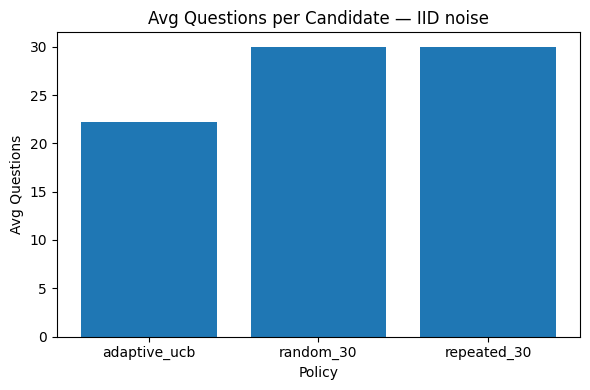

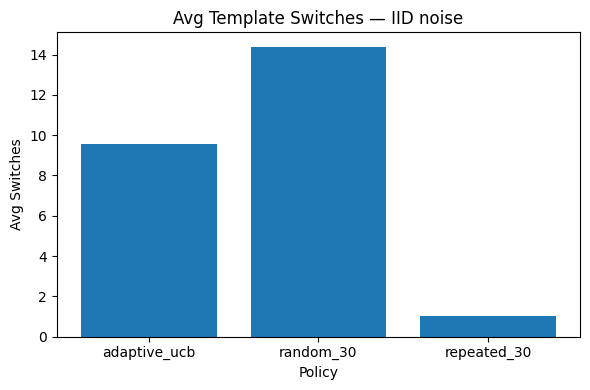

In [11]:

# Plot 1: Avg Questions per Candidate (IID)
plt.figure(figsize=(6,4))
plt.bar(summary_iid["policy"], summary_iid["avg_questions"])
plt.title("Avg Questions per Candidate — IID noise")
plt.ylabel("Avg Questions")
plt.xlabel("Policy")
plt.tight_layout()
plt.show()

# Plot 2: Avg Switches per Session (IID)
plt.figure(figsize=(6,4))
plt.bar(summary_iid["policy"], summary_iid["avg_switches"])
plt.title("Avg Template Switches — IID noise")
plt.ylabel("Avg Switches")
plt.xlabel("Policy")
plt.tight_layout()
plt.show()



## Regime B — Correlated + Biased noise

This is closer to reality with LLM graders (template preferences and persistent offsets).  
Repetition tends to **amplify** bias; adaptive selection **diversifies** evidence and stops sooner.


In [5]:

cfg_corr = Config(n_candidates=1000, max_q=30, tau=3.5, z=1.96, sigma_resid=0.6, rho=0.6, bias_A=0.2, bias_B=-0.2)
df_corr, summary_corr = run_experiment(cfg_corr)
summary_corr.round(3)


/var/folders/_d/q2bd4jnj67x7fhpp0ttf_dw00000gn/T/ipykernel_799/1602641813.py:134: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("policy").apply(pr).reset_index(),


,policy,avg_questions,avg_switches,verified_rate,precision,recall
0,adaptive_ucb,22.13,7.781,0.331,0.819,0.860
1,random_30,30.00,14.500,0.236,0.932,0.698
2,repeated_30,30.00,1.000,0.243,0.938,0.724


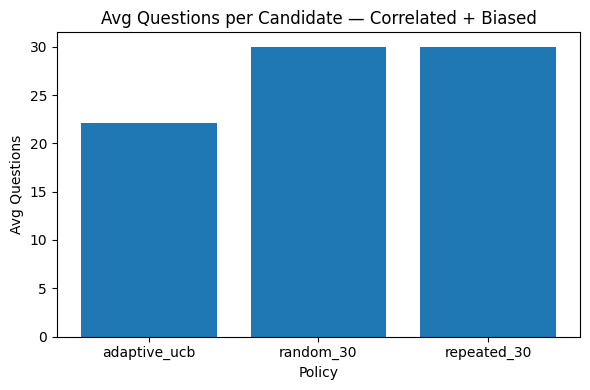

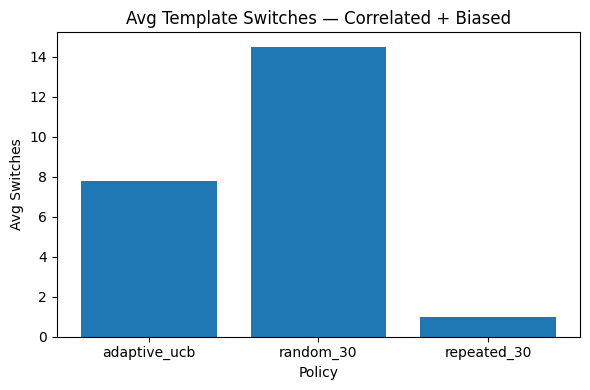

In [6]:

# Plot 1: Avg Questions per Candidate (Correlated + Biased)
plt.figure(figsize=(6,4))
plt.bar(summary_corr["policy"], summary_corr["avg_questions"])
plt.title("Avg Questions per Candidate — Correlated + Biased")
plt.ylabel("Avg Questions")
plt.xlabel("Policy")
plt.tight_layout()
plt.show()

# Plot 2: Avg Switches per Session (Correlated + Biased)
plt.figure(figsize=(6,4))
plt.bar(summary_corr["policy"], summary_corr["avg_switches"])
plt.title("Avg Template Switches — Correlated + Biased")
plt.ylabel("Avg Switches")
plt.xlabel("Policy")
plt.tight_layout()
plt.show()



## Cost overlay (optional)

Translate the speed gain into simple business terms. If an LLM‑graded question costs £0.002:


In [7]:

COST_PER_Q = 0.002

iid_costs = summary_iid.assign(cost=lambda d: d["avg_questions"] * COST_PER_Q)[["policy","avg_questions","cost"]]
corr_costs = summary_corr.assign(cost=lambda d: d["avg_questions"] * COST_PER_Q)[["policy","avg_questions","cost"]]

print("Estimated Cost per Candidate — IID noise")
display(iid_costs.round(4))
print("\nEstimated Cost per Candidate — Correlated + Biased")
display(corr_costs.round(4))


Estimated Cost per Candidate — IID noise


,policy,avg_questions,cost
0,adaptive_ucb,22.214,0.0444
1,random_30,30.000,0.0600
2,repeated_30,30.000,0.0600



Estimated Cost per Candidate — Correlated + Biased


,policy,avg_questions,cost
0,adaptive_ucb,22.13,0.0443
1,random_30,30.00,0.0600
2,repeated_30,30.00,0.0600
